In [1]:
import fix_yahoo_finance as yf
import datetime
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pickle

# Databroker
The DataBroker takes care of the data that we use for the model. 
Keeping an offline version stored for easy use and to reduce download need.

In [2]:
class DataBroker:
    def __init__(self, start_date=datetime.date(2000, 1, 1)):
        self.data = {}
        self.load_data()
        self.start_date = start_date
        self.today = datetime.datetime.now().date() - datetime.timedelta(days=1)
         
    # Reads the pickle file and initiate the data dictionary.
    def load_data(self):
        try:
            self.data = pickle.load(open("data_store.p", "rb"))
        except FileNotFoundError:
            print("No data was found")
            return False
        print(self.data.keys())
        return True
          
    # Write data to the pickle file.
    def save_data(self):
        pickle.dump(self.data, open("data_store.p", "wb"))
        return True
    
    # Updates data for every company to the last day of trading
    def update_all_companies(self):
        for company in self.data.keys():
            self.update_company(company)
        return True
        
    # Updates a the date of a company, if no data exists adds the company to the database. 
    def update_company(self, company):        
        if company in self.data.keys():      
            cur_date = self.data[company].index.max().date()
            diff = (self.today - cur_date).days
            if diff > 0 and diff < 3 and datetime.date.today().weekday() >= 5:
                return True
            elif diff > 0:
                append_data = yf.download([company], start=cur_date, end=self.today)
                self.data[company].append(append_data)
        else:
            self.data[company] = yf.download([company], start=self.start_date, end=self.today)
        self.save_data()
        return True
    
    # Returns the data of collected on a company
    def load_company(self, company, start_date=None, end_date=None):
        if not start_date:
            start_date = self.start_date
        if not end_date: 
            end_date = self.today
        return self.data[company][start_date:end_date]
    
    # Clears the database and overwrites the data-file.
    def clear_database(self):
        self.data = {}
        self.save_data()
        return True
    
    # Returns the "Opening" price for a specific company at a specific date. If no date provided, last day of trading will be used
    def get_company_stock_price(self, company, date):
        if not date:
            return self.data[company]["Open"][-1]
        date_index = self.data[company]["Open"].index.get_loc(date, method='pad')
        return self.data[company]["Open"][date_index]

# Trader
A baseline agent, capable of trading stocks and ready for simulations. 
Contains no trading-logic, and agents should inherit and build trading logic on top of this.

In [3]:
class Trader:
    def __init__(self, DataBroker, start_funds, companies, start_date=datetime.datetime(2000,1,1)):
        self.DataBroker = DataBroker
        self.balance = start_funds
        self.start_funds = start_funds

        self.owning = {}
        self.companies = companies
        
        self.date = start_date
        
    # Updates the date of the Trader. Is used for simulations.
    def set_date(self, date):
        self.date = date
        return True
    
    # Resets the balance back to start and clears the portfolio.
    def reset_balance_and_portfolio(self):
        self.balance = start_funds
        self.owning = {}
        return True
    
    # Retuning a action point of doing nothing for a specific date.
    def do_nothing(self, date):
        return (date, 0, None, 0 ,0)
    
    # Buys x stocks from a company, only if x*price < balance. Adds it to portfolio and updates balance. 
    # Returning the action of buying x stocks 
    def buy_stock(self, date, company, price, amount):
        if amount * price > self.balance:
            return self.do_nothing(date)
        if company in self.owning:
            self.owning[company] = self.owning[company] + amount
        else:
            self.owning[company] = amount 
        self.balance = self.balance - amount * price
        return (date, 1, company, price, amount)
    
    # Sells stocks only if owning said stocks. 
    def sell_stock(self, date, company, price, amount):
        if company not in self.owning or self.owning[company] <= 0:
            return self.do_nothing(date)
        to_sell = min(self.owning[company], amount)
        self.owning[company] = self.owning[company] - to_sell
        self.balance = self.balance + (to_sell * price)
        return (date, -1, company, price, to_sell)
    
    # Getting the value of a portfolio using stock price of 'date' provided, if no date given, last tradingday is used.
    def get_portfolio_worth(self, date=datetime.date.today()):
        worth = 0
        for c in self.owning:
            if self.owning[c] > 0:
                worth = worth + self.DataBroker.get_company_stock_price(c, date) * self.owning[c]
        return worth
    
    # The total worth of the trader, balance + portfolio
    def get_total_worth(self, date=datetime.date.today()):
        return self.balance + self.get_portfolio_worth(date)
    
    # Abstract method to be implemented in each agent
    def predict(self, date):
        # Return a set of actions (do_nothing|buy_stock|sell_stock). This is done to enable multibuy agents 
        # with identical simulation code. 
        # Furthermore, it provides the developer with the choice of allowing multitrade on single days
        """Method shall be implemented in each trader"""
        return 
    
    # Predicting next, used for simulations using the date stored in trader run prediction.
    def predict_next(self):       
        prediction = self.predict(self.date)
        self.date = self.date + datetime.timedelta(days=1)
        return prediction

# Simulater
Helper functions used to simulate one or more Traders using date within a given timeframe. Will provie both profits and actionsets.

In [16]:
# Simulate the Trader acting within 'start_date' and 'end_date', returning the series of actions taken. 
def simulate_trader(Trader, start_date, end_date=datetime.date.today(), no_actions=False):
    Trader.set_date(start_date)
    
    data = [(Trader.date, Trader.start_funds, Trader.start_funds, 0)]
    
    actions = []
    for days in range((end_date-start_date).days):
        action = Trader.predict_next()
        action_date = action[0][0]
        tot_worth = Trader.get_total_worth(action_date)
        to_append = (action_date, tot_worth, Trader.balance, tot_worth - Trader.balance)
        data.append(to_append)
        
        if not(no_actions):
            actions.append(action)
    
    print("{0}; Total worth: {1:1.0f}, Balance: {2:1.0f}, Portfolio worth: {3:1.0f}".format(Trader.name, data[-1][1], data[-1][2], data[-1][3]))
    
    if no_actions:
        return data[-1][1]
    
    return data[-1][1], (Trader.name, Trader.start_funds, data, actions)  

def simulate_traders(Traders, start_date, end_date=datetime.date.today(), no_actions=False):
    res = []
    
    if not isinstance(Traders, list):
        Traders = [Traders]
    
    for Trader in Traders:
        res.append(simulate_trader(Trader, start_date,end_date, no_actions))
    return res

# Visualizer
A set of visualization tools, taking a simulation or a list of simulations as inputs.

In [5]:
from enum import Enum
class Visualize(Enum):
    Tot_worth = 1
    Balance = 2
    Worth = 3
    All = 4
    

In [15]:
def visualize_portfolios(simulation_datas, visualize:Visualize=Visualize.Tot_worth):
    plt.figure(figsize=(20,5))   
    
    if not isinstance(simulation_datas, list):
        simulation_datas = [simulation_datas]
    
    for simulation_data in simulation_datas:

        simulation = simulation_data[1]

        name = simulation[0]
        data = simulation[2]

        balances = []
        tot_worth =[]
        worth = []
        time = []

        for i in data:
            time.append(i[0])
            tot_worth.append(i[1])
            balances.append(i[2])
            worth.append(i[3])
        
        if visualize == Visualize.All:
            plt.plot(time, tot_worth, label=name, linewidth=2.5) 
            plt.plot(time, balances, label=name, linewidth=2.5) 
            plt.plot(time, worth, label=name, linewidth=2.5) 
        elif visualize == Visualize.Balance:
            plt.plot(time, balances, label=name, linewidth=2.5) 
        elif visualize == Visualize.Worth:
            plt.plot(time, worth, label=name, linewidth=2.5) 
        else:
            plt.plot(time, tot_worth, label=name, linewidth=2.5) 
        
    
    plt.xlabel("Time of investment", fontsize=14)
    plt.ylabel("Dollars", fontsize=14)
    plt.title("Portfoliovalue over time", fontsize=18)
    plt.legend()
    plt.show()
    return balances[-1]

In [30]:
def visualize_variations_2d(balances, x, x_label=None):
    fig = plt.figure(figsize=(20,5))
    plt.plot(x, balances, linewidth=2.5)
    plt.ylabel("Balance")
    if x_label:
        plt.xlabel(x_label)
    else:
        plt.xlabel("Variation")
    if x_label:
        plt.title("Performance with variations " + x_label, fontsize=18)
    else:
        plt.title("Performance with variations", fontsize=18)
        
    plt.show()

In [41]:
def visualize_variations_3d(balances, x, y, x_label=None, y_label=None, relative=True):
    dim = len(x)
    
    (x, y) = np.meshgrid(np.array(x), np.array(y))
    z = np.reshape(np.array(balances), (-1, dim))
    
    fig = plt.figure(figsize=(20,10))
    ax = fig.add_subplot(111, projection='3d')
    #surf = ax.plot_surface(x, y, z)
    surf = ax.plot_wireframe(x, y, z)
    scat = ax.scatter(x,y,z)
    
    if x_label:
        ax.set_xlabel(x_label)
    if y_label:
        ax.set_ylabel(y_label)
    ax.set_zlabel("Balance")
    
    ax.set_title("Performance across variations", fontsize=18)
    
    ax.view_init(30, 55)
    
    fig.tight_layout()
    
    plt.show()

# Simple Algo
A simple trader, trading based on low-level math and logic. Trades only a single stock
$$ action = \begin{cases} buy, & if ~ \dfrac{\text{price today}}{mean(\text{x days trading})} > 1 + y \\ 
sell, & if~ \dfrac{\text{price today}}{mean(\text{x days trading})} < 1 - y \\
nothing, & elseway \end{cases} $$

In [9]:
class SimpleTrader(Trader):
    
    def __init__(self, DataBroker, start_funds, start_date, companies, days=5, percent=0.05):
        Trader.__init__(self, DataBroker, start_funds, companies, start_date)
        self.days = days
        self.percent = percent
        
        self.data = self.DataBroker.load_company(self.company)["Open"]
        self.date = self.data.index[0].date()
        
        self.name = 'SimpleTrader_{0}_{1}'.format(days, percent)
        self.owning = {}
        
    def predict(self, date):
        if date not in self.data.index:
            return self.do_nothing(date)
        date_index = self.data.index.get_loc(date)
        df = self.data[max(0, date_index-self.days) : date_index+1]
        mean = np.mean(df[:-1])
        if df[-1] / mean > 1 + self.percent:
            return self.buy_stock(date, self.company, df[-1], 1)
        elif df[-1] / mean < 1 - self.percent:
            return self.sell_stock(date, self.company, df[-1], 100000)
        return self.do_nothing(date)      

# Simple Algo 2

In [56]:
class SimpleTrader2(Trader):
    
    def __init__(self, DataBroker, start_funds, start_date, companies, days=5, percent = 0.05):
        Trader.__init__(self, DataBroker, start_funds, companies, start_date)
        self.name = 'SimpleTrader_{0}_{1}'.format(days, percent)
        self.owning = {}
        
        self.days = days
        self.percent = percent
        
        self.data = {}
        for company in self.companies:
            self.data[company] = self.DataBroker.load_company(company)["Open"]
            if not self.date or (self.data[company].index[0].date() - self.date).days < 0:
                self.date = self.data[company].index[0].date()
        
    def predict(self, date):        
        actions = []
        
        for company in self.companies:
            if date not in self.data[company].index:
                continue
            date_index = self.data[company].index.get_loc(date)
            df = self.data[company][max(0, date_index-self.days) : date_index+1]
            mean = np.mean(df[:-1])
            std = np.std(df[:-1])
            if (df[-1] / mean) > 1 + self.percent:
                actions.append(self.buy_stock(date, company, df[-1], max(1, ( (df[-1]-mean)*(std+1e-6) )*(100*self.percent))))
            elif (df[-1] / mean) < 1- self.percent:
                actions.append(self.sell_stock(date, company, df[-1], 100000))
        
        if len(actions) <= 0:
            return [self.do_nothing(date)]
        
        return actions

# Running it

In [11]:
broker = DataBroker()

dict_keys(['PNDORA.CO', 'VWS.CO', 'DANSKE.CO', 'CHR.CO'])


In [47]:
broker.update_company("TSLA")

[*********************100%***********************]  1 of 1 downloaded


True

In [57]:
agents = []
xs = [i * 0.01 for i in range(1,5)] 
ys = [5, 10, 15]
for y in ys:
    for x in xs:
        agents.append(SimpleTrader2(broker, 100000, datetime.date(2000, 1,1), ["TSLA","NFLX","GOOGL"], days=y, percent=x))
start = datetime.date(2010,1,1)   
#end = datetime.date(2018,2,1)   

simulations = simulate_traders(agents, start)
simulations_balance = [simulation[0] for simulation in simulations]

SimpleTrader_5_0.01; Total worth: 192558, Balance: 24463, Portfolio worth: 168094
SimpleTrader_5_0.02; Total worth: 345777, Balance: 9589, Portfolio worth: 336188
SimpleTrader_5_0.03; Total worth: 276243, Balance: 16601, Portfolio worth: 259643
SimpleTrader_5_0.04; Total worth: 195411, Balance: 35246, Portfolio worth: 160165
SimpleTrader_10_0.01; Total worth: 251943, Balance: 102900, Portfolio worth: 149042
SimpleTrader_10_0.02; Total worth: 325335, Balance: 27250, Portfolio worth: 298085
SimpleTrader_10_0.03; Total worth: 344591, Balance: 190868, Portfolio worth: 153723
SimpleTrader_10_0.04; Total worth: 305293, Balance: 100329, Portfolio worth: 204963
SimpleTrader_15_0.01; Total worth: 320926, Balance: 32446, Portfolio worth: 288480
SimpleTrader_15_0.02; Total worth: 299676, Balance: 67027, Portfolio worth: 232649
SimpleTrader_15_0.03; Total worth: 268758, Balance: 163802, Portfolio worth: 104956
SimpleTrader_15_0.04; Total worth: 372549, Balance: 47192, Portfolio worth: 325358


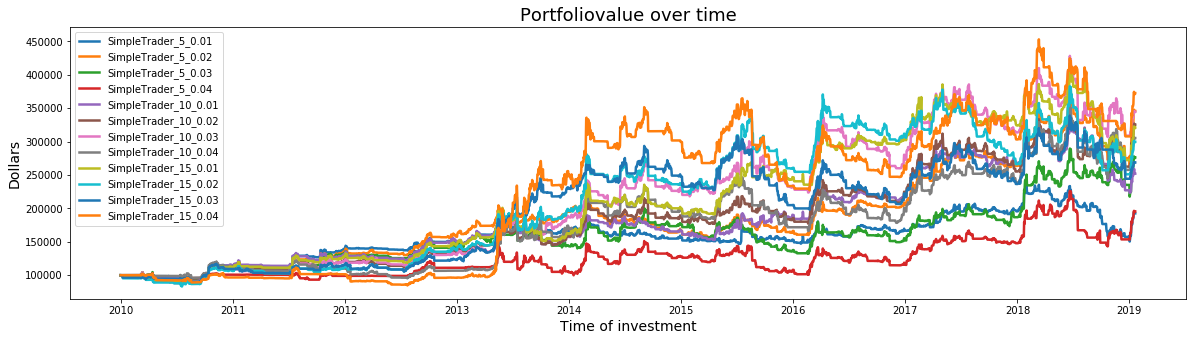

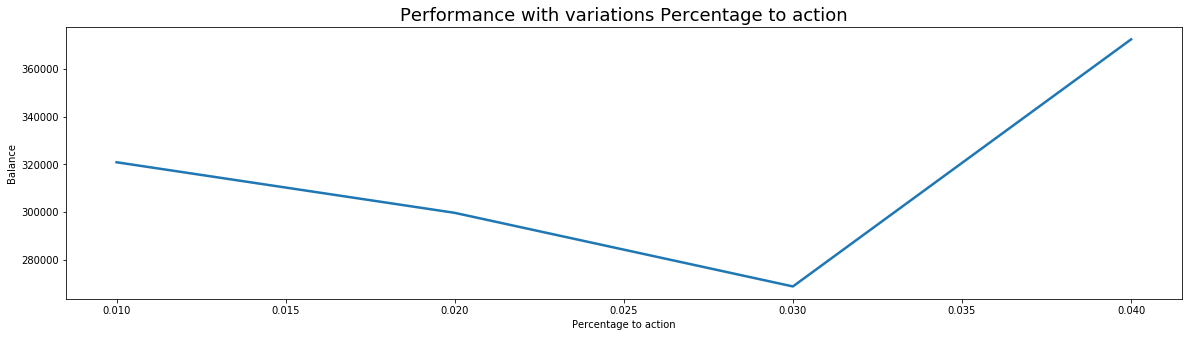

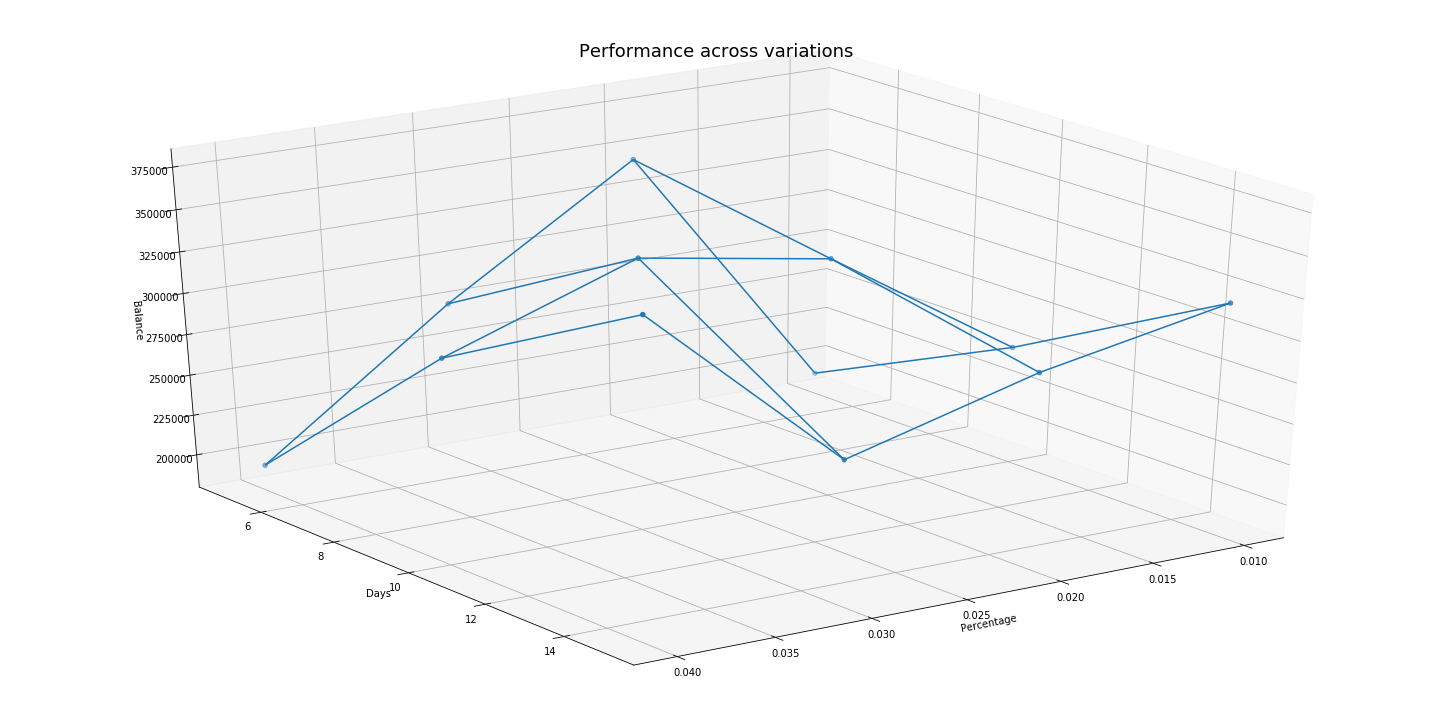

In [58]:
visualize_portfolios(simulations, visualize=Visualize.Tot_worth)
visualize_variations_2d(simulations_balance[len(xs)*2:len(xs)*3], xs, x_label="Percentage to action")
visualize_variations_3d(simulations_balance, xs, ys, x_label="Percentage", y_label="Days")